## 프로젝트 1. 경사 하강법으로 이미지 복원하기

### 프로젝트 개요와 목표

이번 프로젝트에서 우리가 풀 문제는 다음과 같습니다.

이미지 처리를 위해 만들어 두었던 weird_function() 함수에 실수로 버그가 들어가 100×100 픽셀의 오염된 미미지가 만들어졌습니다. 이 오염된 이미지와 오염되기 전 원본 이미지를 동시에 파일로 저장하려고 했으나, 모종의 이유로 원본 이미지 파일은 삭제된 상황입니다. 다행히도 weird_function()의 소스코드는 남아 있습니다. 오염된 이미지와 weird_function()을 활용해 원본 이미지를 복원해봅시다.

*참고자료: https://github.com/jcjohnson/pytorch-examples, NYU Intro2ML*

In [1]:
import torch # 파이토치 import
import pickle # 이미지 파일 로딩할 때 사용하는 pickle library import
import matplotlib.pyplot as plt # matplotlib 라이브러리 import
from google.colab import drive # 구글 드라이브 import
import pdb
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [2]:
shp_original_img = (100, 100) # 이미지 shape
# 오염된 이미지 파일 로딩(pytorch tensor shape)

broken_image =  torch.FloatTensor( pickle.load(open('/gdrive/My Drive/Colab Notebooks/3-min-pytorch-master/03-파이토치로_구현하는_ANN/broken_image_t.p', 'rb'),encoding='latin1' ) )

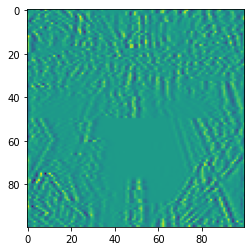

In [3]:
# matplotlib로 100,100으로 바꾼 후 시각화
plt.imshow(broken_image.view(100,100)) 

In [4]:
def weird_function(x, n_iter=5):
    h = x    
    
    #filt = tensor([-0.3333,  0.3333, -0.3333])
    filt = torch.tensor([-1./3, 1./3, -1./3])
    
    for i in range(n_iter):
        # zero_tensor = tensor([0.]) / zero_tensor.shape = torch.Size([1])
        zero_tensor = torch.tensor([1.0*0])     
        
        # zero tensor와 input feature(h, 가상 feature)를 이어붙여 신규 h_l, h_r feature를 제작
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        
        # h_l과 h_r를 일정 비율로 결합하여 h를 업데이트
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        
        if i % 2 == 0:
            h = torch.cat((h[h.shape[0]//2:],h[:h.shape[0]//2]), 0)
            # 짝수 번 반복될때마다 신규 h feature의 앞뒤(5000을 기준)를 바꿔서 이어붙임(5000:) + (:5000)
    return h

In [5]:
# 무작위 텐서(random_tensor)를 weird_function함수에 입력하여 얻은 
# 가설 텐서(hypothesis tensor)와 오염된 이미지 간의 차(=loss)를 구하는 함수
def distance_loss(hypothesis, broken_image):    
    return torch.dist(hypothesis, broken_image)

In [6]:
# 경사하강법을 통해서 향후 원본 이미지의 형상이 될 무작위 tensor
random_tensor = torch.randn(10000, dtype = torch.float)

Loss at 0 = 12.410140037536621
Loss at 1000 = 1.137208342552185
Loss at 2000 = 0.530625581741333
Loss at 3000 = 0.3714474141597748
Loss at 4000 = 0.2963428497314453
Loss at 5000 = 0.24952755868434906
Loss at 6000 = 0.21538910269737244
Loss at 7000 = 0.18793344497680664
Loss at 8000 = 0.1644783765077591
Loss at 9000 = 0.14364735782146454
Loss at 10000 = 0.12464271485805511
Loss at 11000 = 0.10695462673902512
Loss at 12000 = 0.09024026244878769
Loss at 13000 = 0.07425783574581146
Loss at 14000 = 0.05883545055985451
Loss at 15000 = 0.04385066777467728
Loss at 16000 = 0.02921825647354126
Loss at 17000 = 0.02115466073155403
Loss at 18000 = 0.021166088059544563
Loss at 19000 = 0.021167641505599022


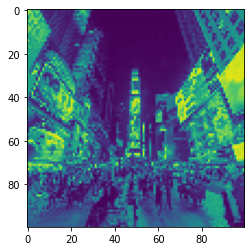

In [7]:
# 학습률(learning rate) = 0.8
lr = 0.8 
for i in range(0,20000):
    # 오차 함수를 random_tensor로 미분해야 하기 때문에 requires_grad를 True로 설정
    random_tensor.requires_grad_(True)

    # random_tensor를 weird_function()함수에 통과하여 hypothesis를 구함.
    hypothesis = weird_function(random_tensor)

    #distance_loss함수에서 hypothesis와 broken_image간 오차(loss)를 계산
    loss = distance_loss(hypothesis, broken_image)
    
    # backward함수로 loss를 random_tensor로 미분
    loss.backward()

    # 직접 gradient descent를 구현하기 위하여 torch.no_grad 함수를
    # 사용하여, 자동 기울기 계산을 비활성화
    with torch.no_grad():
        # random_tensor : loss.backward()에서 계산한 loss의 기울기 --> loss가 최댓값이 되는 방향
        # 이 방향의 반대 방향으로 lr를 이동.
        random_tensor = random_tensor - lr*random_tensor.grad
    # for문이 1000번 반복될때마다 오차 출력
    if i % 1000 == 0:
        print('Loss at {} = {}'.format(i, loss.item()))

# 전체 반복문을 다 돌 경우, random_tensor가 제대로 복원됐는지 확인
plt.imshow(random_tensor.view(100,100).data)